# Author

Daniel Soto

# Draft Status

# Introduction

This notebook uses a mean of the individual regression results from generators to form a composite generator model of the form

$$ \textrm{Fuel Rate} = \textrm{No-Load Consumption} + \beta \cdot P_L $$

Where $\beta$ is the marginal fuel rate per unit of delivered load and $P_L$ is the power delivered by the generator.

This model is applied to the observed power data to predict the fuel use at the loads in the villages.

# Method

- perform regressions and take means
- construct generator fuel use model
- apply model to power data

# Results


# Next Work

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa
import statsmodels.api as sm

/Users/dsoto/miniconda3/envs/wp19/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# load data and add a column for the delivered load in kVA rather than a percentage

gen_data = pd.read_csv('../data_sheets/generator_data.csv', comment='#')
gen_data['load_kVA'] = gen_data['rated_power_kVA'] * gen_data['percent_load'] / 100
gen_data.head()

,manufacturer,model_number,rated_power_kVA,percent_load,fuel_consumption_lph,load_kVA
0,kohler,20REOZK 4D5.0,25.0,100,7.2,25.00
1,kohler,20REOZK 4D5.0,25.0,75,5.7,18.75
2,kohler,20REOZK 4D5.0,25.0,50,3.8,12.50
3,kohler,20REOZK 4D5.0,25.0,25,2.3,6.25
4,kohler,30REOZK 4D8.3,35.0,100,9.1,35.00


In [4]:
# iterate over each model and perform a fit and show table of results

generator_fits = []
models = gen_data['model_number'].unique()
for m in models:
    model_data = gen_data[gen_data['model_number'] == m]
    y = model_data['fuel_consumption_lph']
    X = model_data['load_kVA']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    generator_fits.append({'model': m,
                           'rated_power_kVA':model_data['rated_power_kVA'].mean(), 
                           'no_load_consumption': model.params['const'],
                           'fuel_coefficient': model.params['load_kVA'],
                           'R-squared': model.rsquared})
    
generator_fits = pd.DataFrame(generator_fits)
generator_fits

,R-squared,fuel_coefficient,model,no_load_consumption,rated_power_kVA
0,0.997683,0.265600,20REOZK 4D5.0,0.600000,25.0
1,0.997653,0.230857,30REOZK 4D8.3,1.100000,35.0
2,0.999383,0.242667,40REOZK4 4D8.3,0.700000,45.0
3,0.995408,0.251852,P26-3S 60Hz,1.233333,27.0
4,0.982069,0.235000,P40-3S 60Hz,2.216667,40.0
5,0.999437,0.265455,P50-5S 60Hz,1.150000,55.0
6,0.998700,0.284444,D50-6S SP,1.833333,45.0
7,0.998752,0.272222,D40-6S SP,2.250000,36.0


In [12]:
marginal_fuel_rate = generator_fits['fuel_coefficient'].mean()
no_load_fuel_rate = generator_fits['no_load_consumption'].mean()
print('marginal fuel rate (lph) =', marginal_fuel_rate)
print('no load fuel consumption (lph) =', no_load_fuel_rate)

marginal fuel rate (lph) = 0.256012109187
no load fuel consumption (lph) = 1.38541666667


In [6]:
def get_fuel_rate(load_power=None):
    return load_power * marginal_fuel_rate + no_load_fuel_rate

def get_SFC(load_power=None, fuel_rate=None):
    return fuel_rate / load_power

Specific Fuel Consumption Duration Curves


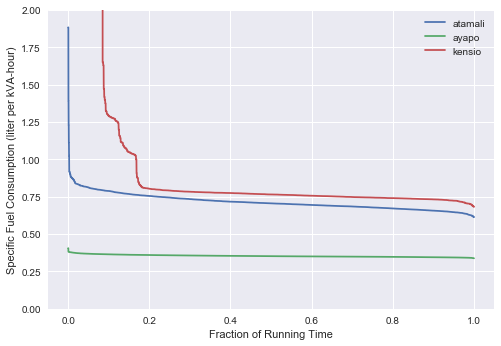

In [7]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    # load power data
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    # create SFC timeseries from load data
    fuel_rate = get_fuel_rate(load_power=kVA)
    fuel_per_kVA_hour = get_SFC(load_power=kVA, fuel_rate=fuel_rate)
    # sort and reverse for duration curve
    fuel_per_kVA_hour.sort()
    fuel_per_kVA_hour = fuel_per_kVA_hour[::-1]
    index = np.linspace(0, 1, len(fuel_per_kVA_hour))
    plt.plot(index, fuel_per_kVA_hour,
             label=vname)

print('Specific Fuel Consumption Duration Curves')
plt.legend()
plt.xlabel('Fraction of Running Time')
plt.ylabel('Specific Fuel Consumption (liter per kVA-hour)')
plt.ylim((0,2))
plt.savefig('../plots/specific_fuel_consumption_duration.png')
plt.show()

In [10]:
tmp_data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    mean_kVA = kVA.mean()
    rated_load = rfd['genset_rating_kVA']
    #load = rating * 1.0
    #specific_fuel_consumption_100 = get_fuel_rate(rating, load) / load 
    SFC_100 = get_SFC(fuel_rate=get_fuel_rate(load_power=rated_load), load_power=rated_load)
    mean_load = mean_kVA
    #specific_fuel_consumption_mean = get_fuel_rate(rating, load) / load
    SFC_mean = get_SFC(fuel_rate=get_fuel_rate(load_power=mean_load), load_power=mean_load)
    tmp_data.append({'Village' : vname.title(),
                 'Genset rating (kVA)' : rfd['genset_rating_kVA'],
                 'expected fuel rate at 100% (lph)' : get_fuel_rate(load_power=rated_load),
                 'mean load (kVA)' : mean_load,
                'expected fuel rate at mean load (lph)' : get_fuel_rate(load_power=mean_load),
                'Expected specific fuel consumption at 100% load (lpkVA)': SFC_100,
                'Expected specific fuel consumption at mean load (lpkVA)': SFC_mean,
                })

data = pd.DataFrame(tmp_data)
#data = data.set_index(['village'])
#data = data[['genset rating kVA', 
#             'expected fuel rate at 100% (lph)', 
#             'mean load (kVA)',
#             'expected fuel rate at mean load (lph)']]
data = data[['Village', 
             'Genset rating (kVA)', 
             'mean load (kVA)',
             'expected fuel rate at 100% (lph)',
             'expected fuel rate at mean load (lph)',
             'Expected specific fuel consumption at 100% load (lpkVA)',
             'Expected specific fuel consumption at mean load (lpkVA)']]

data

,Village,Genset rating (kVA),mean load (kVA),expected fuel rate at 100% (lph),expected fuel rate at mean load (lph),Expected specific fuel consumption at 100% load (lpkVA),Expected specific fuel consumption at mean load (lpkVA)
0,Atamali,25.0,3.057530,7.785719,2.168181,0.311429,0.709128
1,Ayapo,40.0,14.323494,11.625901,5.052404,0.290648,0.352735
2,Kensio,35.0,2.451428,10.345840,2.013012,0.295595,0.821159
